# Extended Data Fig 2

## Setup

In [1]:
# Set working directory
%cd notebooks
# Autoreload
%load_ext autoreload
%autoreload 2
# Use rpy2 to run R in python notebook for plotting
%load_ext rpy2.ipython

/home/jovyan/work/notebooks


In [51]:
%%R 
source("../code/fig_extended.R")

In [2]:
# Import local code
import sys
sys.path.append('/home/jovyan/work/code')
from gradientVersion import *
from processing import *
from analysis_helpers import *
from triplets import *
from enrichments_data import *
from enrichments import *
from single_cell import *
from brainspan import *
from maps_data import *
from maps_analysis import *
from maps_null_test import *
from disorders_data import *
from disorders import *

In [3]:
pca_base = gradientVersion(approach='pca', kernel=None).fit('hcp_base')
dme_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3d_ds5')

New gradients version: method=pca, kernel=None, sparsity=0, data=hcp_base
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3d_ds5


In [4]:
weights = dme_3d_ds5.weights.iloc[:,:3]
null_weights = shuffle_gene_weights(weights, n=5000, rank=False)

---

### Parameter choices

In [ ]:
base = get_expression_abagen(fetch_hcp(), verbose=0)

# Define variations of processing parameters to test
variations = {
    'gene_stability_threshold': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'donors_threshold': [3,2,1],
    'lr_mirror': [None],
    'ibf_threshold': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'tolerance': [0,4],
    'sim_threshold': [2],
    'agg_metric': ['median'],
    'sample_norm': [None, 'center', 'zscore', 'rs'],
    'gene_norm': [None, 'center', 'zscore', 'rs'],
    'probe_selection': ['max_intensity', 'mean', 'rnaseq']
}
defaults = {
    'gene_stability_threshold': 0.0,
    'donors_threshold': 0,
    'lr_mirror': 'bidirectional',
    'ibf_threshold': 0.5,
    'tolerance': 2,
    'probe_selection': 'diff_stability',
    'sim_threshold': None,
    'agg_metric': 'mean',
    'sample_norm': 'srs',
    'gene_norm': 'srs'
}

# Reset if desired
robustness_data = {}
# robustness_data = robustness_data_3d_ds5

# Process data with one parameter varied, and save
for parameter, values in variations.items():
    print(f'--- Processing values of {parameter} ---')
    robustness_data[parameter] = {}
    for v in values:
        # Reset kwargs to default values
        kwargs = defaults.copy()
        # Update one value
        kwargs[parameter] = v
        exp = get_expression_abagen(fetch_hcp(), verbose=0, **kwargs)
        robustness_data[parameter][v] = exp
        print(f'Done {parameter}={v}')

# For each parameter, insert the default data as base
for parameter, default_value in defaults.items():
    robustness_data[parameter][default_value] = base

save_pickle(robustness_data, 'robustness_data_base')

In [5]:
# save_pickle(robustness_data, 'robustness_data_base')
# save_pickle(robustness_data, 'robustness_data_3d_ds8')
# save_pickle(robustness_data, 'robustness_data_3d_ds5')
# save_pickle(robustness_data, 'robustness_data_ds8')
# robustness_data_base = load_pickle('robustness_data_base')
# robustness_data_3d_ds8 = load_pickle('robustness_data_3d_ds8')
robustness_data_3d_ds5 = load_pickle('robustness_data_3d_ds5')
# robustness_data_ds8 = load_pickle('robustness_data_ds8')

In [6]:
def get_robustness_corrs(base_model, robustness_data, approach='pca', test_dme_robustness=False):
    robustness_corrs = {}
    for parameter, values in robustness_data.items():
        robustness_corrs[parameter] = {}
        for value, data in values.items():
            name_to_print = f'{parameter}:{value}'
            model = gradientVersion(approach=approach).fit(data, message=False)
            # corrs = model.corr_scores(base_model, match=True)['corr']
            corrs = pd.Series(np.diag(model.corr_scores(base_model, match=False)))
            robustness_corrs[parameter][value] = np.abs(corrs)
            print(f"Compared components with {name_to_print}")
    
    # test base model against variations of DME parameters
    if test_dme_robustness:
        robustness_corrs['alpha'] = {}
        for alpha in [0,0.5]:
            name_to_print = f'alpha:{alpha}'
            data = base_model.expression
            model = gradientVersion(approach=approach, alpha=alpha).fit(data, message=False)
            corrs = pd.Series(np.diag(model.corr_scores(base_model, match=False)))
            robustness_corrs['alpha'][alpha] = np.abs(corrs)
            print(f"Compared components with {name_to_print}")

        robustness_corrs['kernel'] = {}
        for kernel in ['gaussian', 'cosine', 'pearson']:
            name_to_print = f'kernel:{kernel}'
            data = base_model.expression
            model = gradientVersion(approach=approach, kernel=kernel).fit(data, message=False)
            corrs = pd.Series(np.diag(model.corr_scores(base_model, match=False)))
            robustness_corrs['kernel'][kernel] = np.abs(corrs) 
            print(f"Compared components with {name_to_print}")
            
    return robustness_corrs

In [7]:
robustness_corrs = {
    # 'pca_base': get_robustness_corrs(pca_base, robustness_data_base, approach='pca'),
    'dme_3d_ds5': get_robustness_corrs(dme_3d_ds5, robustness_data_3d_ds5, approach='dm', test_dme_robustness=True),
}

Compared components with gene_stability_threshold:0.0
Compared components with gene_stability_threshold:0.1
Compared components with gene_stability_threshold:0.2
Compared components with gene_stability_threshold:0.3
Compared components with gene_stability_threshold:0.4
Compared components with gene_stability_threshold:0.5
Compared components with gene_stability_threshold:0.6
Compared components with gene_stability_threshold:0.7
Compared components with gene_stability_threshold:0.8
Compared components with gene_stability_threshold:0.9
Compared components with donors_threshold:3
Compared components with donors_threshold:2
Compared components with donors_threshold:1
Compared components with lr_mirror:None
Compared components with ibf_threshold:0.0
Compared components with ibf_threshold:0.2
Compared components with ibf_threshold:0.5
Compared components with ibf_threshold:0.8
Compared components with tolerance:0
Compared components with tolerance:4
Compared components with probe_selection:m

In [8]:
robustness = {}
for version_name, version_corrs in robustness_corrs.items():
    version_dict = {param:pd.concat(value_corrs) for param, value_corrs in version_corrs.items()}
    robustness[version_name] = pd.concat(version_dict)
robustness = (pd.concat(robustness)
  .reset_index()
  .set_axis(['version','parameter', 'value', 'C', 'corr'], axis=1)
  .assign(value = lambda x: x['value'].astype('str'))
)
robustness

,version,parameter,value,C,corr
0,dme_3d_ds5,gene_stability_threshold,0.0,0,0.998003
1,dme_3d_ds5,gene_stability_threshold,0.0,1,0.962977
2,dme_3d_ds5,gene_stability_threshold,0.0,2,0.930412
3,dme_3d_ds5,gene_stability_threshold,0.0,3,0.789451
4,dme_3d_ds5,gene_stability_threshold,0.0,4,0.839766
...,...,...,...,...,...
185,dme_3d_ds5,kernel,pearson,0,0.039875
186,dme_3d_ds5,kernel,pearson,1,0.112263
187,dme_3d_ds5,kernel,pearson,2,0.036921
188,dme_3d_ds5,kernel,pearson,3,0.011838


In [9]:
# Remove identity rows
# drops = [
#   ('pca_hcp_3d_ds8','gene_stability_threshold',0.8),
#   ('dm_hcp_3d_ds5','gene_stability_threshold',0.5),
#   ('dm_hcp_ds8','gene_stability_threshold',0.8),
#   ('pca_hcp_3d_ds8','donors_threshold',3),
#   ('dm_hcp_3d_ds5','donors_threshold',3),
#   ('dm_hcp_ds8','donors_threshold',1)
# ]

robustness = {}
for version_name, version_corrs in robustness_corrs.items():
    version_dict = {param:pd.concat(value_corrs) for param, value_corrs in version_corrs.items()}
    robustness[version_name] = pd.concat(version_dict)
robustness = (pd.concat(robustness)
  # .drop(index=drops)
  .reset_index()
  .set_axis(['version','parameter', 'value', 'C', 'corr'], axis=1)
  .assign(value = lambda x: x['value'].astype('str'))
)
# robustness


# Replace names of some value parameters for plot
robustness['value'] = robustness['value'].replace({'nan':'none',})
robustness.loc[lambda x: x['parameter']=='gene_stability_threshold', 'value'] = \
  robustness.loc[lambda x: x['parameter']=='gene_stability_threshold', 'value'] \
  .apply(lambda ds: f'top {100-round(float(ds)*100)}%').replace({'top 100%':'all genes'})

robustness.loc[lambda x: x['parameter']=='donors_threshold', 'value'] = \
  robustness.loc[lambda x: x['parameter']=='donors_threshold', 'value'] \
  .replace({'1':'all regions', '2': '2+ donors', '3': '3+ donors'})

# Replace parameter names for plot
parameter_names = {
    'gene_stability_threshold': 'Differential stability\ngene filter',
    'donors_threshold': 'Donors/region filter',
    'lr_mirror': 'Right hemi samples\nDefault: mirror',
    'ibf_threshold': 'Gene intensity filter\nDefault: 0.5',
    'sim_threshold': 'Probe similarity threshold\nDefault: none',
    'probe_selection': 'Probe-to-gene selection\nDefault: differential stability',
    'tolerance': 'Sample-to-region \nmatching tolerance\nDefault: 2',
    'agg_metric': 'Sample-to-region aggregation\nDefault: mean',
    'sample_norm': 'Sample normalization\nDefault: scaled robust sigmoid',
    'gene_norm': 'Gene normalization\nDefault: scaled robust sigmoid',
    'kernel': 'DME kernel parameter\nDefault: normalized cosine',
    'alpha': 'DME alpha parameter\nDefault: 1',
}
robustness['parameter'] = pd.Categorical(robustness['parameter'].map(parameter_names),
                          categories=parameter_names.values(), ordered=True)

# Replace version names for plot
version_names = {
    'pca_base': 'PCA, all genes,\nall regions',
    'dme_3d_ds5': 'DME, 50% genes,\n3+ donor regions'
}
robustness['version'] = robustness['version'].map(version_names)
robustness['value'] = pd.Categorical(robustness['value'], 
                      categories=robustness['value'].unique(), ordered=True)
robustness = robustness.sort_values(['parameter', 'value'])

# Identify self rows
robustness['self'] = False
robustness.loc[lambda x: (x['version'].str.contains('PCA')) & 
                         (x['parameter'].str.contains('gene filter')) & 
                         (x['value'].str.contains('top 20%')),
               'self'] = True
robustness.loc[lambda x: (x['version'].str.contains('DME, 50%')) & 
                         (x['parameter'].str.contains('gene filter')) & 
                         (x['value'].str.contains('top 50%')),
               'self'] = True
robustness.loc[lambda x: (x['version'].str.contains('DME, 20%')) & 
                         (x['parameter'].str.contains('gene filter')) & 
                         (x['value'].str.contains('top 20%')),
               'self'] = True
robustness.loc[lambda x: (x['version'].str.contains('PCA')) & 
                         (x['parameter'].str.contains('Donors/region')) & 
                         (x['value'].str.contains('3+')),
               'self'] = True
robustness.loc[lambda x: (x['version'].str.contains('DME, 50%')) & 
                         (x['parameter'].str.contains('Donors/region')) & 
                         (x['value'].str.contains('3+')),
               'self'] = True
robustness.loc[lambda x: (x['version'].str.contains('DME, 20%')) & 
                         (x['parameter'].str.contains('Donors/region')) & 
                         (x['value'].str.contains('all regions')),
               'self'] = True

# Filter for plot
robustness = (robustness
              .loc[lambda x: x['version'] == 'DME, 50% genes,\n3+ donor regions']
              .loc[lambda x: x['parameter'] != 'Probe similarity threshold\nDefault: none']
)

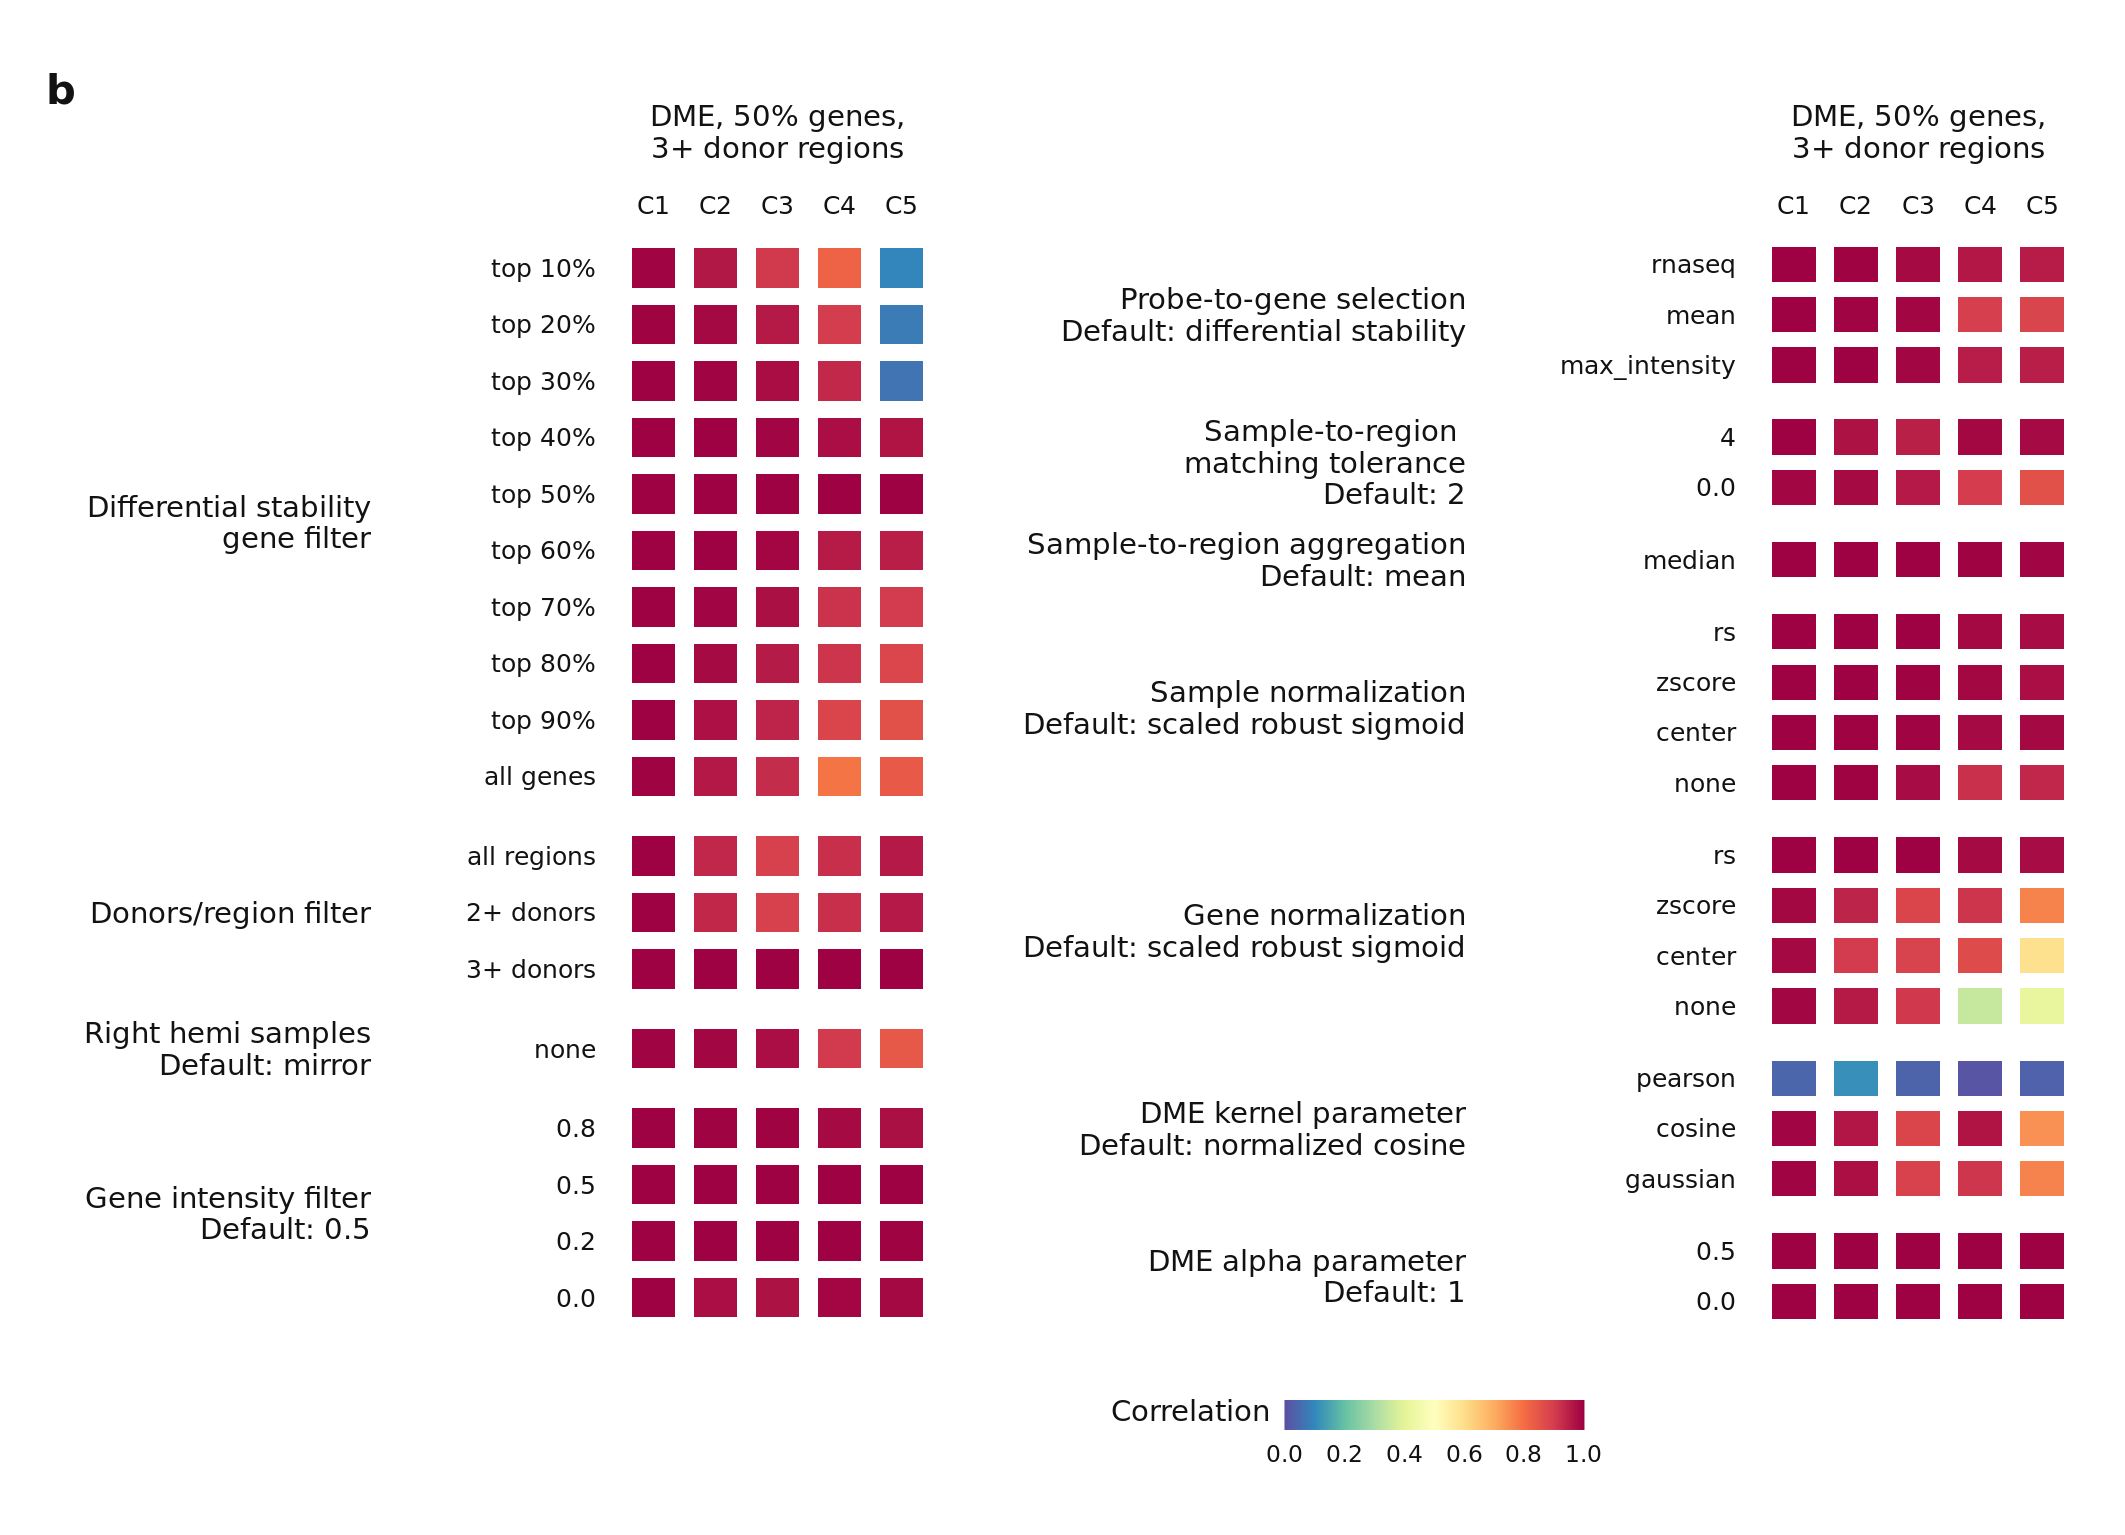

In [15]:
%%R -w 180 -h 130 -r 300 --units mm -i robustness
# robustness %>% filter(grepl('Gene', parameter))
robustness <- robustness %>%
mutate(version = factor(version, ordered=T, levels=unique(.$version))) %>%
mutate(parameter = factor(parameter, ordered=T, levels=unique(.$parameter))) %>%
mutate(value = factor(value, ordered=T, levels=unique(.$value))) %>%
mutate(C = factor(C, levels=c(0,1,2,3,4), labels=c('C1','C2','C3','C4','C5')))

parameters_left <- c(
  'Differential stability\ngene filter',
  'Donors/region filter',
  'Right hemi samples\nDefault: mirror',
  'Gene intensity filter\nDefault: 0.5'
)

plot_robustness <- function(robustness) {
    robustness %>% 
    ggplot(aes(x=C, y=value, fill=corr)) + 
    facet_grid(parameter~version, scales='free_y', space='free', switch='y') + #, scales='free_x', switch='x') + 
    geom_tile(aes(alpha=self), width=.7, height=.7) + #, color='grey50', size=.5) +
    # geom_text(aes(label='★'), data=robustness %>% filter(corr>0.6), color='gray30', size=5) +
    scale_alpha_manual(values=c(1,1), guide='none') +
    scale_fill_gradientn(
            colors=rev(brewer.spectral(100)),
          #   colors=cubicl(100),
            limits=c(0,1.001), breaks=seq(0,1,.2),
            oob = squish,
            labels=c('0.0', '0.2', '0.4', '0.6', '0.8', '1.0'),
            name='Correlation'
    ) +
    coord_cartesian(clip='off') +
    scale_x_discrete(position='top') +
    # guides(fill=guide_colorbar(barwidth=20)) +
    guides(fill=guide_colorbar(barwidth=5, barheight=0.5, ticks=FALSE, title.vjust=1)) +
    ylab('') + xlab('') +
    theme_minimal() +
    theme(
      text=element_text(size=7, family='Calibri', color='grey7'),
      axis.text=element_text(size=6, family='Calibri', color='grey7'),
      panel.grid=element_blank(),
      panel.spacing=unit(1,'mm'),
      legend.position='bottom',
      strip.placement='outside',
      strip.text.x=element_text(size=7, family='Calibri', color='grey7'),
      strip.text.y.left=element_text(size=7, family='Calibri', color='grey7', 
                  angle=0, hjust=1, margin=margin(r=20)),
      plot.tag.position = c(0, .97),
      plot.tag = element_text(size=10, face='bold', family='Calibri', hjust=0, color='grey7')
      # plot.margin=margin(l=10,r=30,t=10,b=10)
    )
}

robustness_left <- robustness %>% filter(parameter %in% parameters_left) %>% plot_robustness + labs(tag='b')
robustness_right <- robustness %>% filter(!(parameter %in% parameters_left)) %>% plot_robustness
 
g_robustness <- (robustness_left | robustness_right) + plot_layout(guides='collect')
g_robustness

### Parcellation

In [1040]:
# get_expression_abagen(fetch_dk(), donors_threshold=3, gene_stability_threshold=0.5, save_name='dk_3d_ds5')
# get_expression_abagen(fetch_dx(), donors_threshold=3, gene_stability_threshold=0.5, save_name='dx_3d_ds5')
# get_expression_abagen(fetch_schaefer(size=400), donors_threshold=3, gene_stability_threshold=0.5, save_name='s400_3d_ds5')

INFO: Donor-specific atlases provided; using native coords for tissue samples
INFO: Reannotating probes with information from Arnatkevic̆iūtė et al., 2019, NeuroImage
INFO: Filtering probes with intensity-based threshold of 0.5
INFO: 32669 probes survive intensity-based filtering
INFO: Reducing probes indexing same gene with method: diff_stability
INFO: 15946 genes remain after probe filtering + selection
INFO: 460 / 477 samples matched to regions for donor #9861
INFO: 346 / 367 samples matched to regions for donor #10021
INFO: 179 / 181 samples matched to regions for donor #12876
INFO: 261 / 263 samples matched to regions for donor #14380
INFO: 223 / 224 samples matched to regions for donor #15496
INFO: 235 / 240 samples matched to regions for donor #15697
INFO: Aggregating samples to regions with provided region_agg: donors


33 / 69 regions remain after filtering for regions with samples from >= 3 donors
4784 / 15946 genes remain after filtering for top 0.3 stability
Expression matrix saved to ../data/abagen-data/expression/dk_3d_ds7.csv


INFO: Donor-specific atlases provided; using native coords for tissue samples
INFO: Reannotating probes with information from Arnatkevic̆iūtė et al., 2019, NeuroImage
INFO: Filtering probes with intensity-based threshold of 0.5
INFO: 32669 probes survive intensity-based filtering
INFO: Reducing probes indexing same gene with method: diff_stability
INFO: 15946 genes remain after probe filtering + selection
INFO: 460 / 477 samples matched to regions for donor #9861
INFO: 346 / 367 samples matched to regions for donor #10021
INFO: 179 / 181 samples matched to regions for donor #12876
INFO: 261 / 263 samples matched to regions for donor #14380
INFO: 223 / 224 samples matched to regions for donor #15496
INFO: 235 / 240 samples matched to regions for donor #15697
INFO: Aggregating samples to regions with provided region_agg: donors


33 / 69 regions remain after filtering for regions with samples from >= 3 donors
3190 / 15946 genes remain after filtering for top 0.2 stability
Expression matrix saved to ../data/abagen-data/expression/dk_3d_ds8.csv


gene_symbol,A1BG,ABCA6,ABCA9,ABCC1,ABCC12,ABCC6,ABCC8,ABCG4,ABCG5,ABHD12B,...,ZNRF1,ZRANB3,ZSCAN18,ZSCAN29,ZSCAN31,ZSCAN5A,ZSCAN9,ZSWIM4,ZSWIM9,ZYX
label,,,,,,,,,,,,,,,,,,,,,
1,0.466261,0.502016,0.529000,0.578403,0.588101,0.509327,0.568392,0.564823,0.409405,0.545998,...,0.514137,0.534718,0.546902,0.428955,0.567839,0.465917,0.522364,0.471382,0.530216,0.589163
2,0.621202,0.377459,0.424607,0.310352,0.219332,0.490775,0.257265,0.301345,0.552878,0.456975,...,0.461979,0.477593,0.669603,0.304555,0.229864,0.606767,0.291163,0.339044,0.691170,0.237261
3,0.531708,0.536333,0.545548,0.525847,0.695947,0.519386,0.569550,0.553402,0.715543,0.670401,...,0.480788,0.455645,0.375597,0.725530,0.419257,0.600494,0.479751,0.551378,0.488998,0.599561
4,0.327959,0.765143,0.706637,0.700680,0.282282,0.167629,0.795858,0.646799,0.388741,0.178147,...,0.271263,0.210956,0.138609,0.712863,0.807663,0.237967,0.789104,0.716972,0.196576,0.846857
5,0.708189,0.403196,0.530491,0.349112,0.296955,0.679258,0.082266,0.290737,0.301913,0.227273,...,0.778370,0.482179,0.648434,0.239870,0.246583,0.761889,0.332742,0.255255,0.739295,0.093821
6,0.618361,0.423677,0.457685,0.441901,0.542940,0.557602,0.427091,0.422130,0.351824,0.364727,...,0.606022,0.560999,0.655793,0.402705,0.497921,0.528516,0.420035,0.398916,0.513879,0.418461
7,0.384924,0.531424,0.625903,0.543789,0.554929,0.470779,0.577660,0.584306,0.371374,0.452795,...,0.430021,0.399776,0.395535,0.530567,0.578461,0.419991,0.570533,0.572632,0.537906,0.606423
8,0.607224,0.390198,0.444563,0.418196,0.659162,0.623952,0.441743,0.379617,0.393004,0.389317,...,0.629672,0.546521,0.665455,0.408005,0.467457,0.488372,0.377632,0.428756,0.589455,0.390367
9,0.386225,0.559015,0.617566,0.532430,0.351473,0.617116,0.526707,0.576097,0.486478,0.403974,...,0.312580,0.386514,0.401027,0.425860,0.412628,0.391797,0.521210,0.577503,0.606150,0.460450


In [16]:
dme_dk_3d_ds5 = gradientVersion(approach='dm').fit('dk_3d_ds5')
dme_dx_3d_ds5 = gradientVersion(approach='dm').fit('dx_3d_ds5')
dme_s400_3d_ds5 = gradientVersion(approach='dm').fit('s400_3d_ds5')

New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=dk_3d_ds5
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=dx_3d_ds5
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=s400_3d_ds5


In [17]:
hcp_scores = dme_3d_ds5.clean_scores()
dk_scores  = dme_dk_3d_ds5.clean_scores()
dx_scores  = dme_dx_3d_ds5.clean_scores()
s400_scores = (dme_s400_3d_ds5.scores
               .iloc[:,:3].set_axis(['C1','C2','C3'],axis=1)
               .apply(lambda x: (x-np.mean(x))/np.std(x))
               .join(get_labels_schaefer(size=400).drop_duplicates())
            )

In [18]:
corrs_dict = {
    'HCP-MMP': correlate(dme_3d_ds5.weights, dme_3d_ds5.weights),
    'Schaefer-400': correlate(dme_s400_3d_ds5.weights, dme_3d_ds5.weights),
    'Destrieux': correlate(dme_dx_3d_ds5.weights, dme_3d_ds5.weights),    
    'Desikan-Killiany': correlate(dme_dk_3d_ds5.weights, dme_3d_ds5.weights),
}

weight_corrs = (pd.concat(corrs_dict)
 .melt(ignore_index=False)
 .reset_index()
 .set_axis(['version','x','y','corr'], axis=1)
 .assign(comparison = 'HCP-MMP')
)

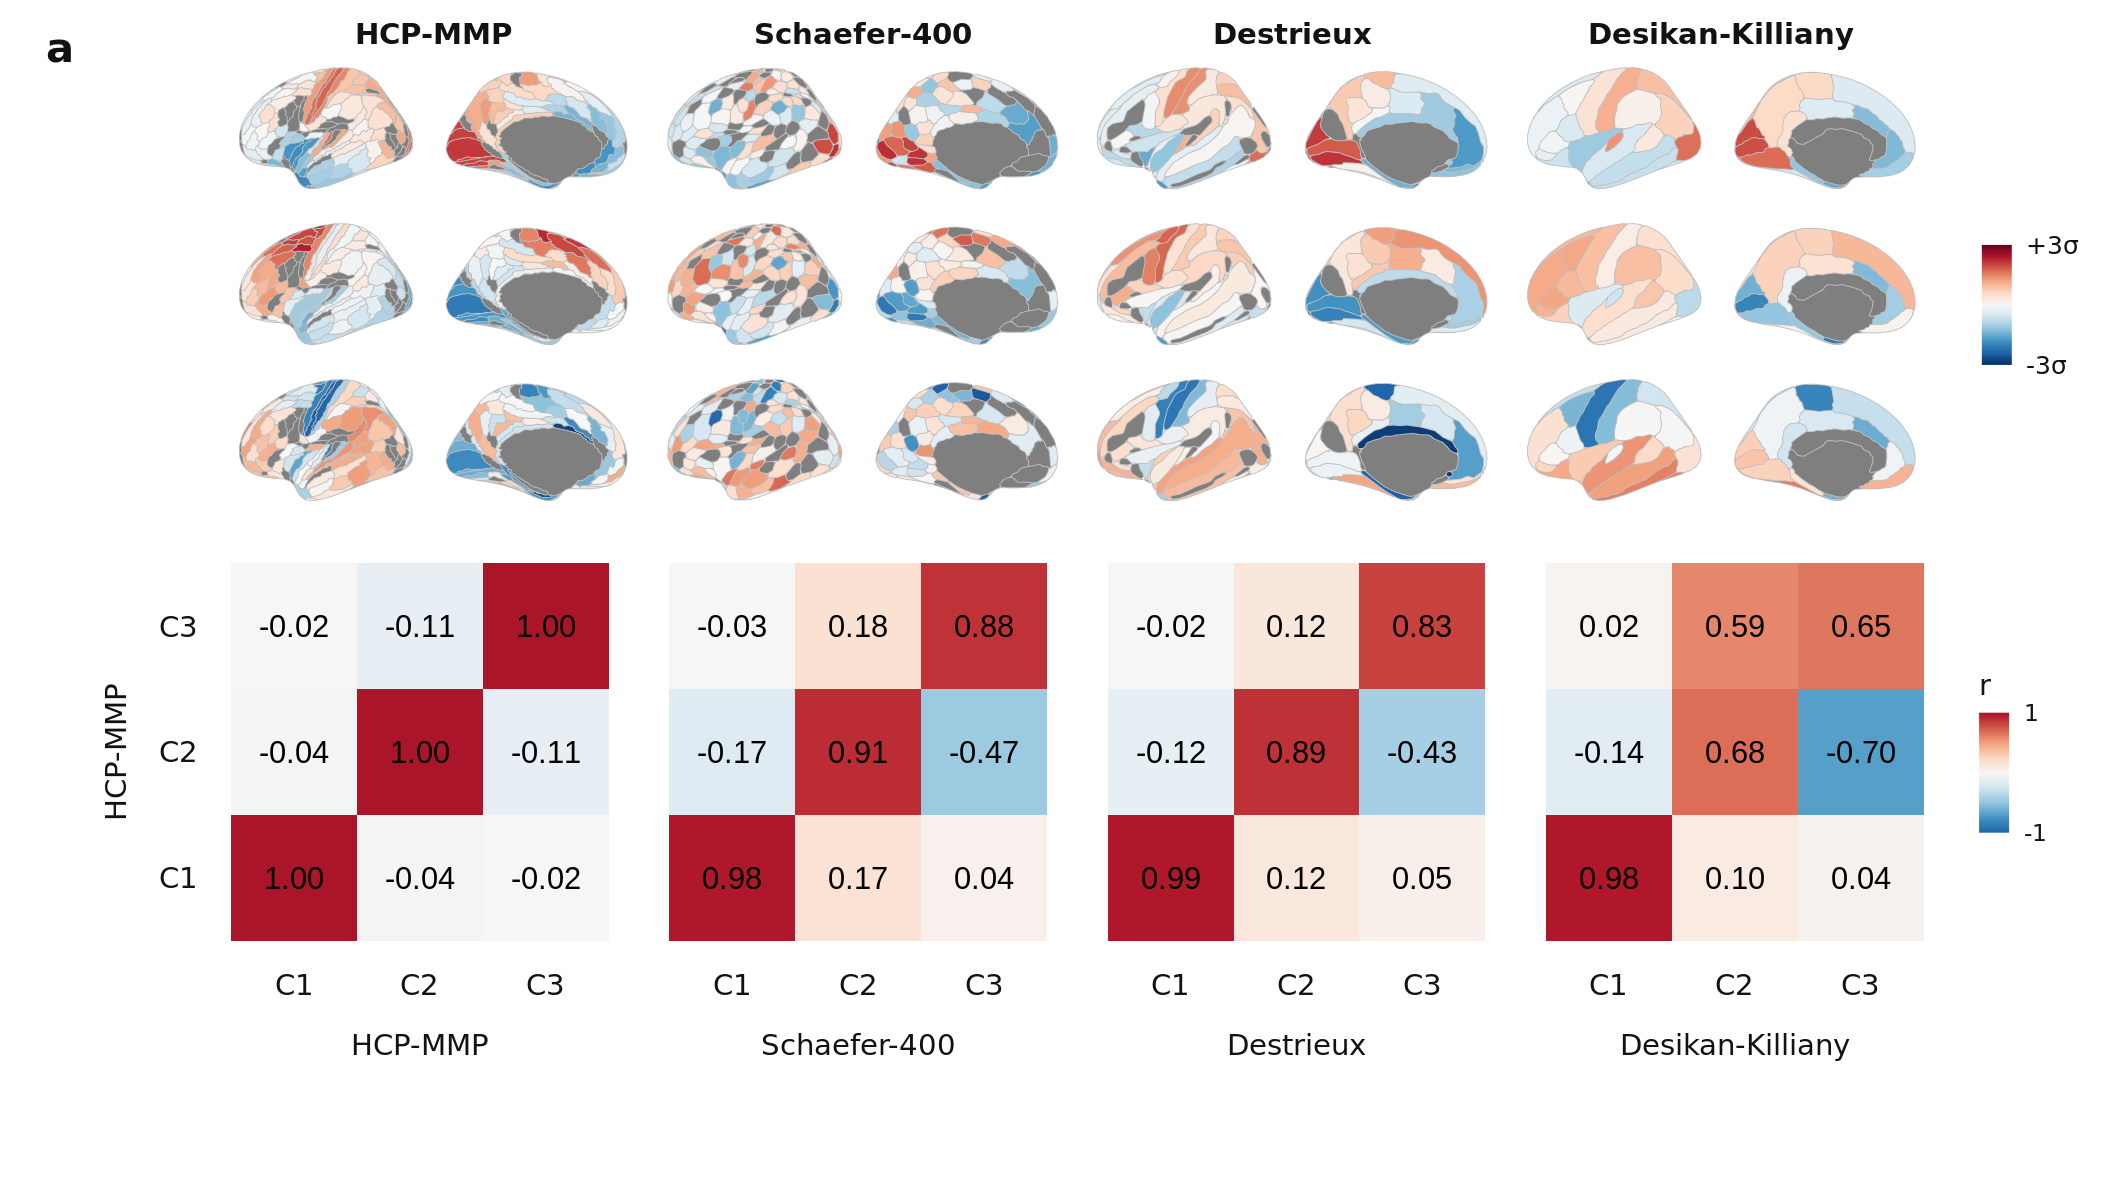

In [21]:
%%R -w 180 -h 100 -u mm -r 300 -i hcp_scores -i dk_scores -i dx_scores -i s400_scores -i weight_corrs
source("../code/fig_extended.R")

brain_hcp <- plot_brains(hcp_scores, facet='v', atlas='hcp') + ggtitle('HCP-MMP') + labs(tag='a')
brain_s400 <- plot_brains(s400_scores, facet='v', atlas='s400') + ggtitle('Schaefer-400')
brain_dx <- plot_brains(dx_scores, facet='v', atlas='dx') + ggtitle('Destrieux')
brain_dk <- plot_brains(dk_scores, facet='v', atlas='dk') + ggtitle('Desikan-Killiany')

brains <- brain_hcp + brain_s400 + brain_dx + brain_dk + plot_layout(ncol=4, guides='collect') & theme(legend.position='right')
heatmaps <- plot_weight_heatmaps(weight_corrs, spacing=3, ylab='HCP-MMP')

g_parcellation <- brains / heatmaps
g_parcellation

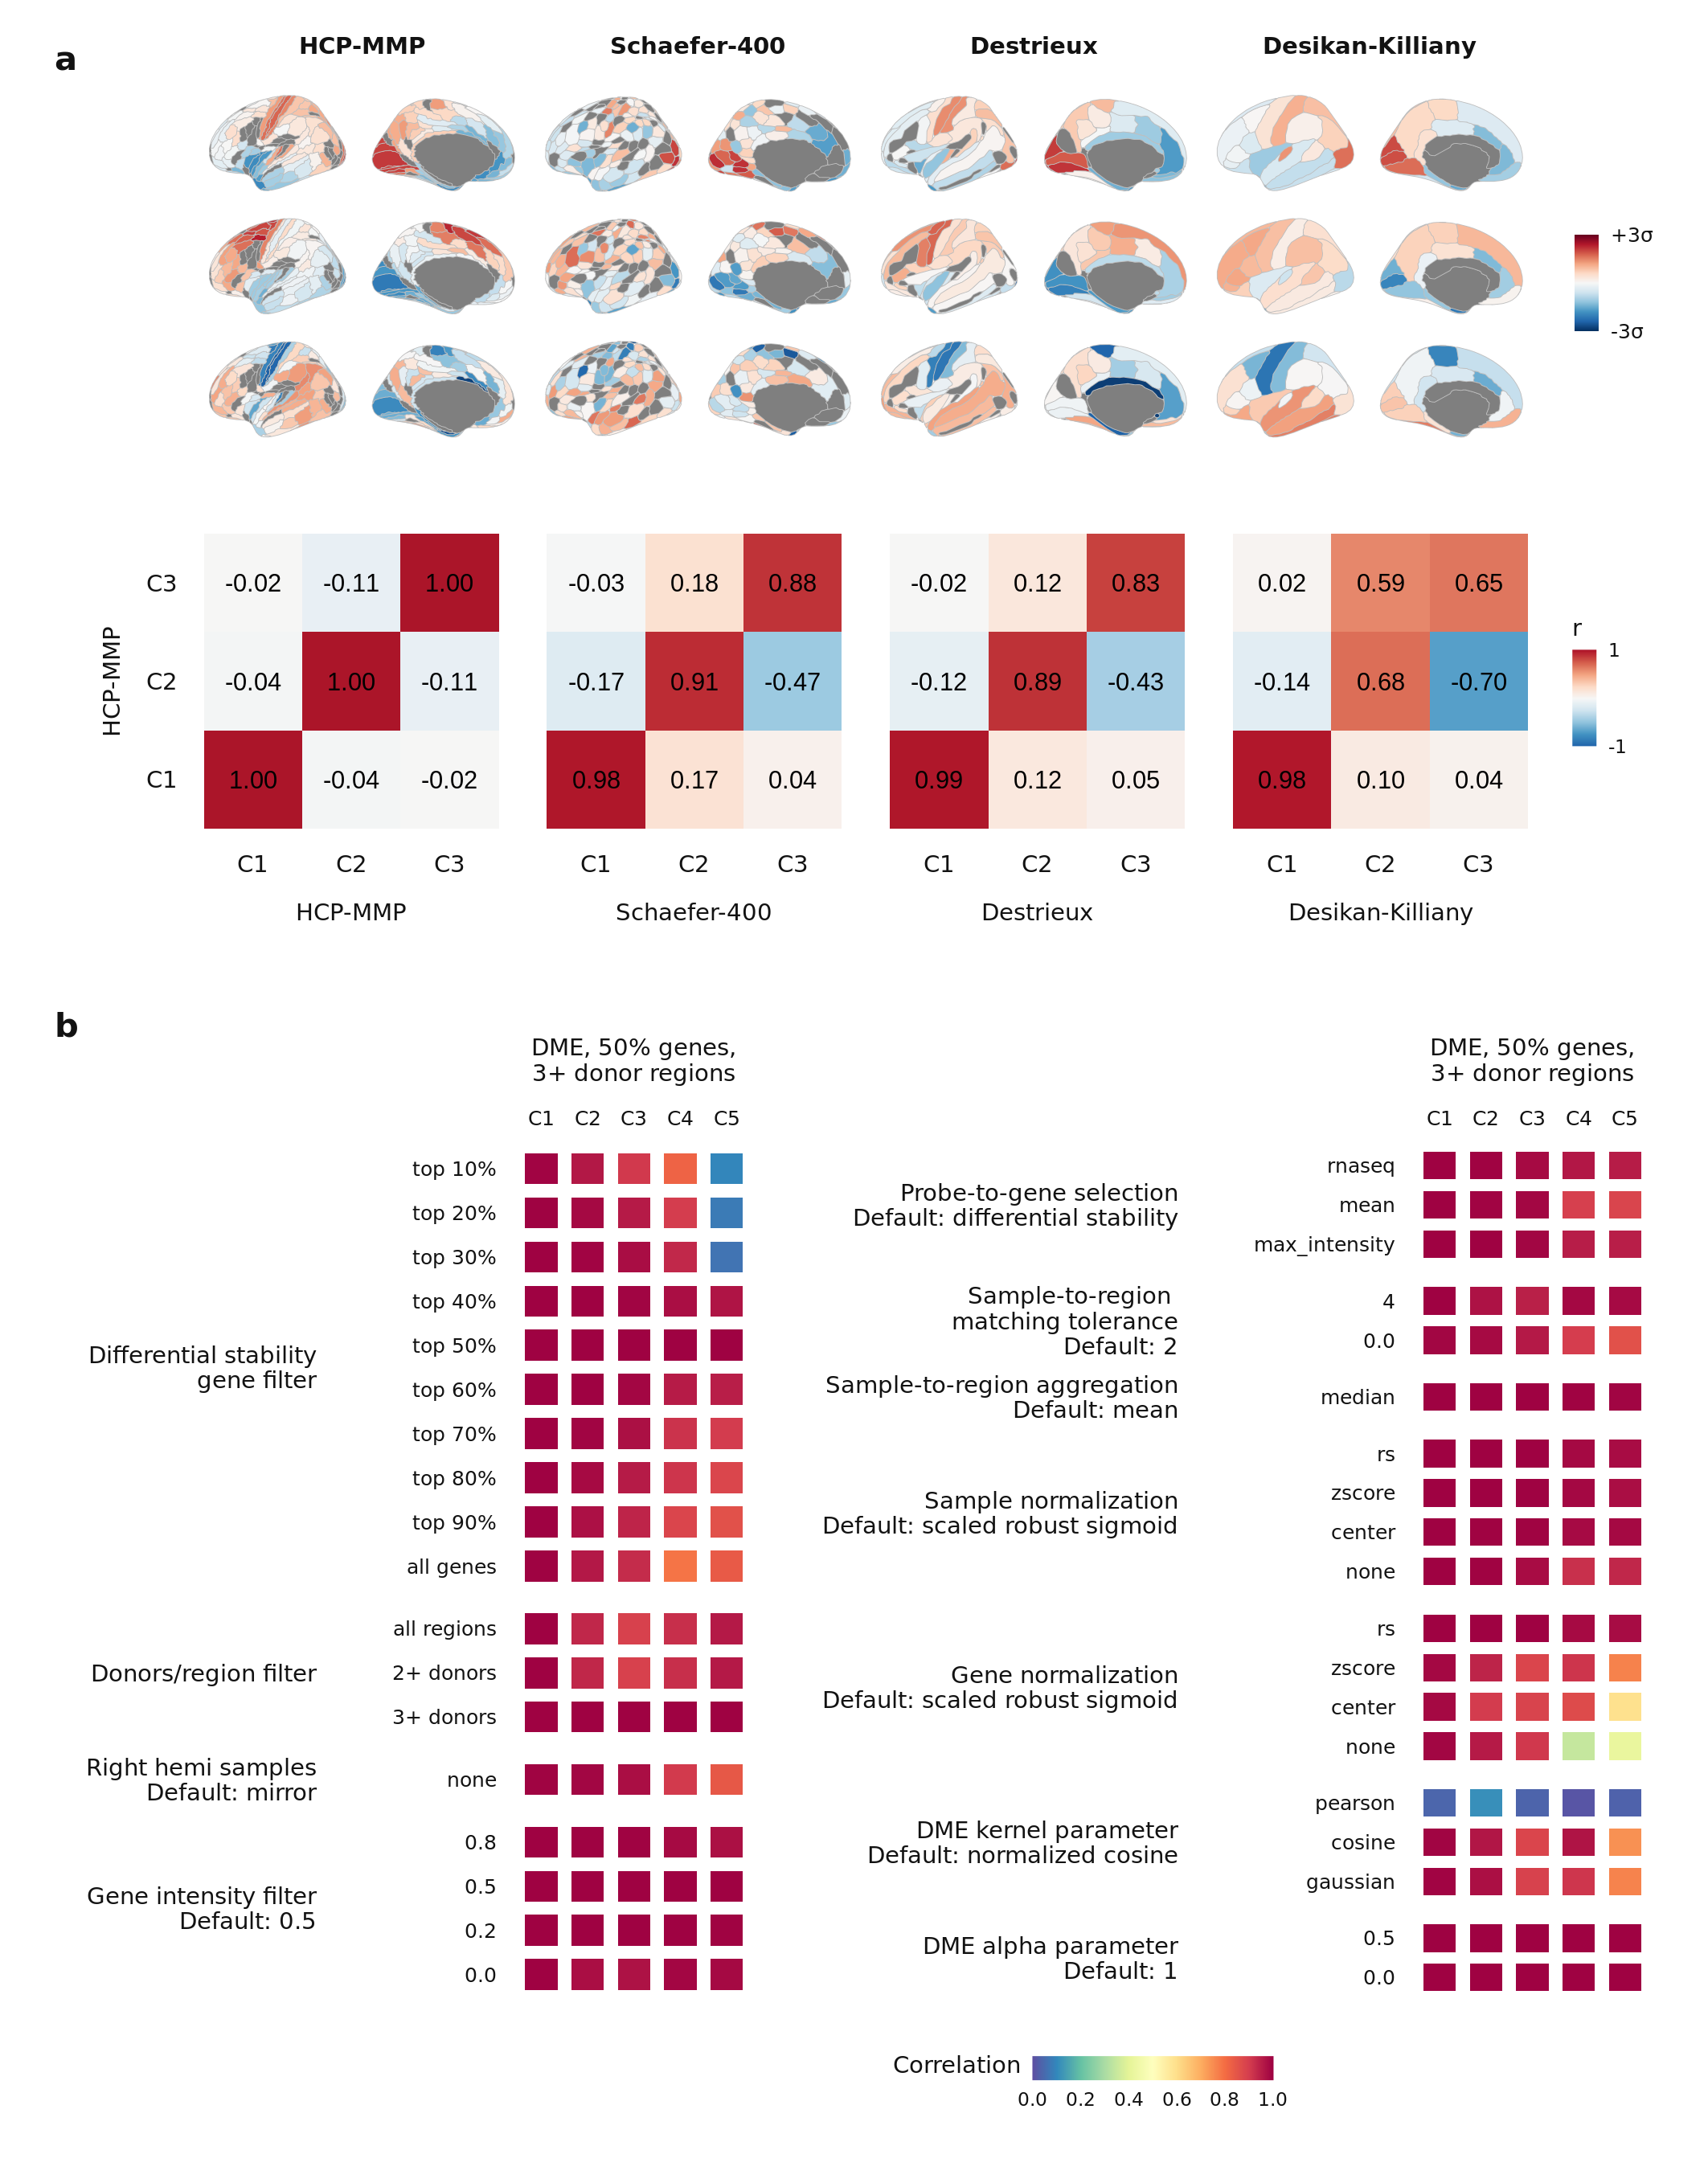

In [49]:
%%R -w 180 -h 230 -u mm -r 300

layout <- c(
    area(t=1,b=110,l=1,r=180),
    area(t=101,b=230,l=1,r=180)
)

plot <- wrap_elements(g_parcellation) + wrap_elements(g_robustness) + plot_layout(design=layout)
annotated <- plot + plot_annotation(theme=theme(plot.margin=margin(0,0,0,0)))
annotated

In [50]:
%%R
ggsave(file="../outputs/figures/fig_ext_2.svg", plot=annotated, width=180, height=230, units='mm')